# Libs

In [1]:
import os
import sys
import json
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets
from tqdm import tqdm
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import cv2
from PIL import Image, ImageFile
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.optimizers import Adam
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import time

2025-06-14 14:07:40.754376: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749910061.202771      77 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749910061.314566      77 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Initialization

In [2]:
# It's crucial to set the mixed precision policy *globally* and *early*.
# Do this BEFORE any model definition or Trainer instantiation.
tf.keras.mixed_precision.set_global_policy('mixed_float16')

# Configure environment for Pillow
ImageFile.LOAD_TRUNCATED_IMAGES = True
Image.MAX_IMAGE_PIXELS = None

train_images_path = "/kaggle/input/driver-inattention-detection-dataset/train"
annotation_file_path = "/kaggle/input/driver-inattention-detection-dataset/train/_annotations.txt"

# These labels from the original datasets 
class_names = {
    0: 'DangerousDriving', 1: 'Distracted', 2: 'Drinking',
    3: 'SafeDriving', 4: 'SleepyDriving', 5: 'Yawn'
}

annotation_viz = {}

batch_size = 16


# Dataset
base_dir = "/kaggle/input/driver-inattention-detection-dataset"

# train
train_images = os.path.join(base_dir, 'train')
train_annotations = os.path.join(train_images, "_annotations.txt")

# val
val_images = os.path.join(base_dir, 'valid')
val_annotations = os.path.join(val_images, "_annotations.txt")

# test
test_images = os.path.join(base_dir, 'test')
test_annotations = os.path.join(test_images, "_annotations.txt")

print(train_images, val_images, test_images)

/kaggle/input/driver-inattention-detection-dataset/train /kaggle/input/driver-inattention-detection-dataset/valid /kaggle/input/driver-inattention-detection-dataset/test


# Parse annotations & Load cropped faces

In [3]:
def parse_annotation_line(line):
    """
    Parses a single line from the annotation file.
    Expected format: image_filename x_min,y_min,x_max,y_max,class_label
    """
    parts = line.strip().split(' ')
    if len(parts) < 2:
        print(f"Warning: Skipping malformed line: {line}")
        return None, None, None
        
    image_filename = parts[0]
    coords_and_label_str = parts[1]
    
    try:
        coords_parts = coords_and_label_str.split(',')
        if len(coords_parts) != 5:
            print(f"Warning: Malformed coordinates/label for {image_filename}: {coords_and_label_str}")
            return image_filename, None, None
            
        x_min = int(coords_parts[0])
        y_min = int(coords_parts[1])
        x_max = int(coords_parts[2])
        y_max = int(coords_parts[3])
        class_label = int(coords_parts[4])
        
        return image_filename, (x_min, y_min, x_max, y_max), class_label
    except ValueError as e:
        print(f"Warning: Error parsing coordinates/label for {image_filename}: {coords_and_label_str} - {e}")
        return image_filename, None, None
    
def load_and_crop_images(annotation_file_path, images_directory):
    """
    Loads image paths and metadata based on an annotation file.
    Returns a list of (image_path, bbox, label) tuples.
    """
    processed_data = []
    
    if not os.path.exists(annotation_file_path):
        print(f"Error: Annotation file not found at {annotation_file_path}")
        return processed_data
        
    if not os.path.isdir(images_directory):
        print(f"Error: Images directory not found at {images_directory}")
        return processed_data

    with open(annotation_file_path, 'r') as f:
        for line in f:
            image_filename, bbox, label = parse_annotation_line(line)
            
            if image_filename is None or bbox is None or label is None:
                continue

            image_path = os.path.join(images_directory, image_filename)
            
            if not os.path.exists(image_path):
                print(f"Warning: Image file not found: {image_path}")
                continue
                
            processed_data.append((image_path, bbox, label))
            
    return processed_data

# Dataset & Preprocessing

In [4]:
class CustomDatasetTF:
    def __init__(self, root_dir, annotation_file, class_names, batch_size=16):
        self.root_dir = root_dir
        self.batch_size = batch_size
        self.class_names = list(class_names.keys())
        self.num_classes = len(self.class_names)

        # Load image paths and metadata
        self.cropped_data = load_and_crop_images(annotation_file, self.root_dir)
        if not self.cropped_data:
            raise RuntimeError("No valid cropped faces loaded!")

    def _load_and_preprocess_image(self, image_path, bbox, label):
        # Read and decode the image
        image = tf.io.read_file(image_path)
        image = tf.image.decode_jpeg(image, channels=3)

        # Convert bbox to tensor
        x_min = bbox[0]
        y_min = bbox[1]
        x_max = bbox[2]
        y_max = bbox[3]
        
        # Get image dimensions
        img_shape = tf.shape(image)
        img_h = img_shape[0]
        img_w = img_shape[1]
        
        # Ensure coordinates are within image bounds
        x_min = tf.maximum(0, x_min)
        y_min = tf.maximum(0, y_min)
        x_max = tf.minimum(img_w, x_max)
        y_max = tf.minimum(img_h, y_max)
        
        # Calculate crop dimensions
        crop_height = y_max - y_min
        crop_width = x_max - x_min
        
        # Crop the image
        image = tf.image.crop_to_bounding_box(
            image, y_min, x_min, crop_height, crop_width
        )

        # Resize the image to a fixed size
        target_size = (224, 224)
        image = tf.image.resize(image, target_size)
        
        # Convert to float and normalize
        image = tf.cast(image, tf.float32)
        image = (image / 127.5) - 1.0 
        
        # # Normalize with ImageNet stats
        # mean = tf.constant([0.485, 0.456, 0.406])
        # std = tf.constant([0.229, 0.224, 0.225])
        # image = (image - mean) / std
        
        return image, label

    def create_dataset(self, shuffle=True):
        if not self.cropped_data:
            print(f"Warning: No samples in CustomDatasetTF for {self.root_dir} to create tf.data.Dataset from.")
            return None
            
        # Create dataset from paths and metadata
        image_paths = [s[0] for s in self.cropped_data]
        bboxes = [s[1] for s in self.cropped_data]
        labels = [s[2] for s in self.cropped_data]
    
        # Create the dataset
        dataset = tf.data.Dataset.from_tensor_slices((image_paths, bboxes, labels))
    
        # Map the preprocessing function
        dataset = dataset.map(
            self._load_and_preprocess_image,
            num_parallel_calls=tf.data.AUTOTUNE
        )

        # One-hot encode the labels
        def to_one_hot(image, label):
            label = tf.cast(label, tf.int32)
            label_one_hot = tf.one_hot(label, depth=self.num_classes, dtype=tf.float32)
            return image, label_one_hot
        
        dataset = dataset.map(to_one_hot, num_parallel_calls=tf.data.AUTOTUNE)

        # Define augmentation function
        # def augment(image, label):
        #     image = tf.image.random_brightness(image, 0.2)
        #     image = tf.image.random_contrast(image, 0.8, 1.2)
        #     image = tf.image.random_flip_left_right(image)
        #     image = tf.image.random_flip_up_down(image)
        #     image = tf.image.rot90(image, k=tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))
        #     return image, label
    
        if shuffle:
            # # Apply augmentation
            # dataset = dataset.map(
            #     augment,
            #     num_parallel_calls=tf.data.AUTOTUNE
            # )

            # Shuffle the dataset
            buffer_size = min(len(self.cropped_data), 10000) 
            if buffer_size > 0: 
                dataset = dataset.shuffle(buffer_size=buffer_size, reshuffle_each_iteration=True)
    
        # Batch and prefetch
        dataset = dataset.batch(self.batch_size)
        dataset = dataset.prefetch(tf.data.AUTOTUNE)
    
        return dataset

In [5]:
def load_dataset(images, annotation, class_names, batch_size=16):
    dataset = CustomDatasetTF(
        root_dir=images,
        annotation_file=annotation,
        class_names=class_names,
        batch_size=batch_size
    )
    
    # Create the dataset
    tf_dataset = dataset.create_dataset(shuffle=False)
    
    # Initialize empty lists for images and labels
    all_images = []
    all_labels = []
    
    # Process each batch
    print(f"Loading dataset from {images}...")
    for image_batch, label_batch in tf_dataset:
        # Convert to numpy and append
        for i in range(len(image_batch)):
            all_images.append(image_batch[i].numpy())
            all_labels.append(label_batch[i].numpy())
    
    # Stack into proper numpy arrays
    X = np.array(all_images)
    y = np.array(all_labels)
    
    print(f"Loaded {len(X)} images with shape {X.shape}")
    return X, y

# Train
X_train, y_train = load_dataset(
    images=train_images,
    annotation=train_annotations,
    class_names=class_names,
    batch_size=16
)

# Validation
X_val, y_val = load_dataset(
    images=val_images,
    annotation=val_annotations,
    class_names=class_names,
    batch_size=16
)

# Test
X_test, y_test = load_dataset(
    images=test_images,
    annotation=test_annotations,
    class_names=class_names,
    batch_size=16
)

I0000 00:00:1749910116.248412      77 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1749910116.249153      77 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Loading dataset from /kaggle/input/driver-inattention-detection-dataset/train...
Loaded 11948 images with shape (11948, 224, 224, 3)
Loading dataset from /kaggle/input/driver-inattention-detection-dataset/valid...
Loaded 1922 images with shape (1922, 224, 224, 3)
Loading dataset from /kaggle/input/driver-inattention-detection-dataset/test...
Loaded 985 images with shape (985, 224, 224, 3)


# Statistics & Visualization

Training Data:

Class Distribution:
  Class 0 (DangerousDriving): 3732 samples (31.24%)
  Class 1 (Distracted): 1676 samples (14.03%)
  Class 2 (Drinking): 347 samples (2.90%)
  Class 3 (SafeDriving): 4969 samples (41.59%)
  Class 4 (SleepyDriving): 785 samples (6.57%)
  Class 5 (Yawn): 439 samples (3.67%)


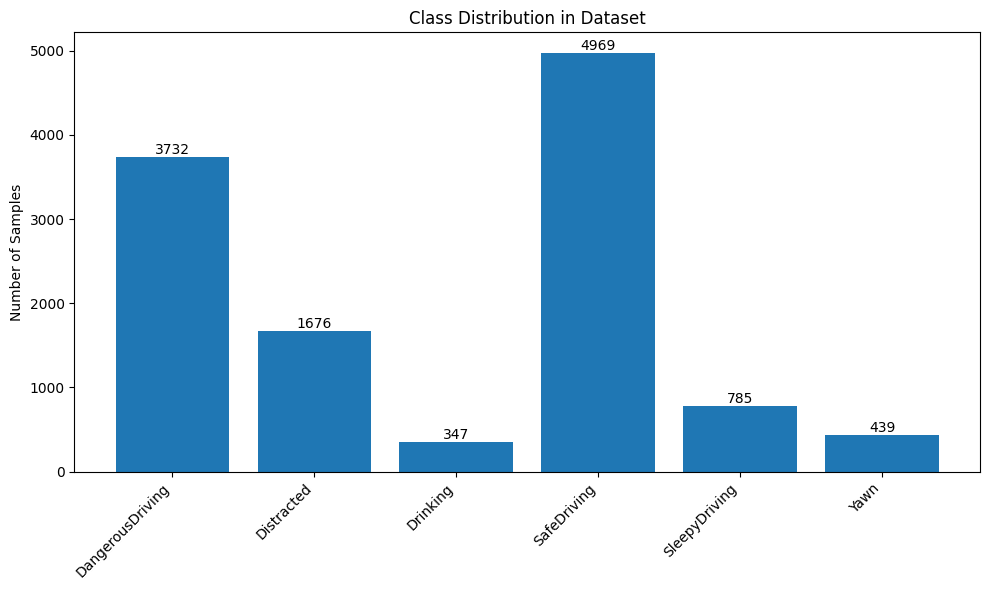


Validation Data:

Class Distribution:
  Class 0 (DangerousDriving): 609 samples (31.69%)
  Class 1 (Distracted): 252 samples (13.11%)
  Class 2 (Drinking): 56 samples (2.91%)
  Class 3 (SafeDriving): 799 samples (41.57%)
  Class 4 (SleepyDriving): 125 samples (6.50%)
  Class 5 (Yawn): 81 samples (4.21%)


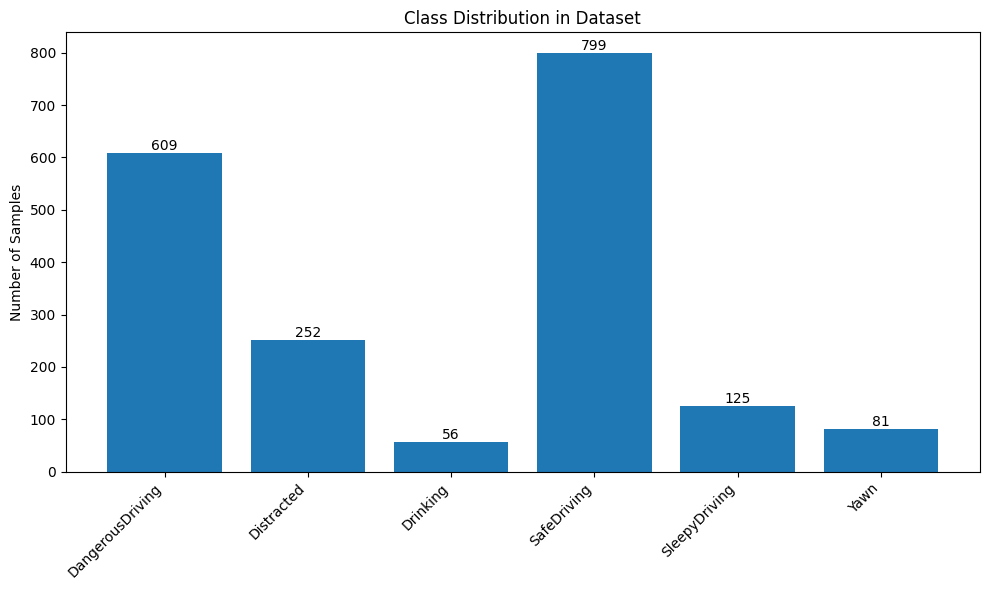


Test Data:

Class Distribution:
  Class 0 (DangerousDriving): 301 samples (30.56%)
  Class 1 (Distracted): 152 samples (15.43%)
  Class 2 (Drinking): 25 samples (2.54%)
  Class 3 (SafeDriving): 412 samples (41.83%)
  Class 4 (SleepyDriving): 69 samples (7.01%)
  Class 5 (Yawn): 26 samples (2.64%)


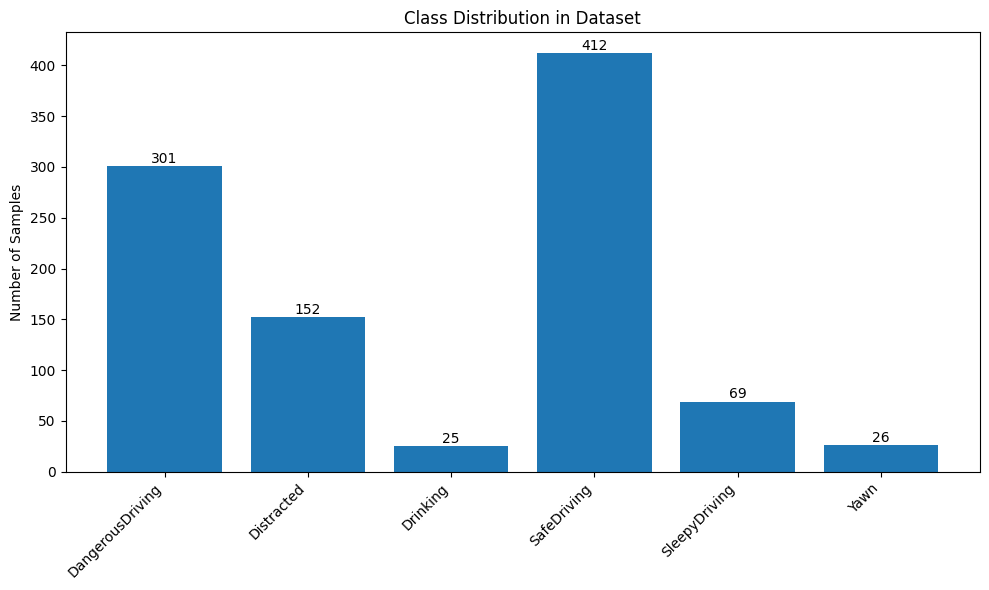

In [6]:
def check_class_distribution(labels, class_names):
    """Check and visualize class distribution in a dataset"""
    class_indices = np.argmax(labels, axis=1)
    classes, counts = np.unique(class_indices, return_counts=True)
    
    print("\nClass Distribution:")
    for i, (cls, count) in enumerate(zip(classes, counts)):
        class_name = class_names[cls] if cls in class_names else f"Unknown Class {cls}"
        print(f"  Class {cls} ({class_name}): {count} samples ({count/len(labels)*100:.2f}%)")
    
    # Plot distribution
    plt.figure(figsize=(10, 6))
    bars = plt.bar(
        [class_names[cls] if cls in class_names else f"Class {cls}" for cls in classes], 
        counts
    )
    
    # Add count labels on top of each bar
    for bar in bars:
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width()/2., height + 0.1,
            f'{int(height)}', ha='center', va='bottom'
        )
    
    plt.title('Class Distribution in Dataset')
    plt.ylabel('Number of Samples')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# Check distribution for each dataset
print("Training Data:")
check_class_distribution(y_train, class_names)

print("\nValidation Data:")
check_class_distribution(y_val, class_names)

print("\nTest Data:")
check_class_distribution(y_test, class_names)

In [7]:
def check_data_ranges(images, name="Dataset"):
    """Verify the range of values in your image data"""
    print(f"\n{name} Statistics:")
    print(f"  Shape: {images.shape}")
    print(f"  Data Type: {images.dtype}")
    print(f"  Min Value: {images.min()}")
    print(f"  Max Value: {images.max()}")
    print(f"  Mean: {images.mean():.4f}")
    print(f"  Std Dev: {images.std():.4f}")
    
    # Check for NaN or infinity values
    n_nan = np.isnan(images).sum()
    n_inf = np.isinf(images).sum()
    if n_nan > 0 or n_inf > 0:
        print(f"  WARNING: Found {n_nan} NaN values and {n_inf} infinity values")

# Check ranges for each dataset
check_data_ranges(X_train, "Training Data")
check_data_ranges(X_val, "Validation Data")
check_data_ranges(X_test, "Test Data")


Training Data Statistics:
  Shape: (11948, 224, 224, 3)
  Data Type: float32
  Min Value: -1.0
  Max Value: 1.0
  Mean: -0.3053
  Std Dev: 0.5098

Validation Data Statistics:
  Shape: (1922, 224, 224, 3)
  Data Type: float32
  Min Value: -1.0
  Max Value: 1.0
  Mean: -0.3046
  Std Dev: 0.5123

Test Data Statistics:
  Shape: (985, 224, 224, 3)
  Data Type: float32
  Min Value: -1.0
  Max Value: 1.0
  Mean: -0.3016
  Std Dev: 0.5121


Training Data Samples:


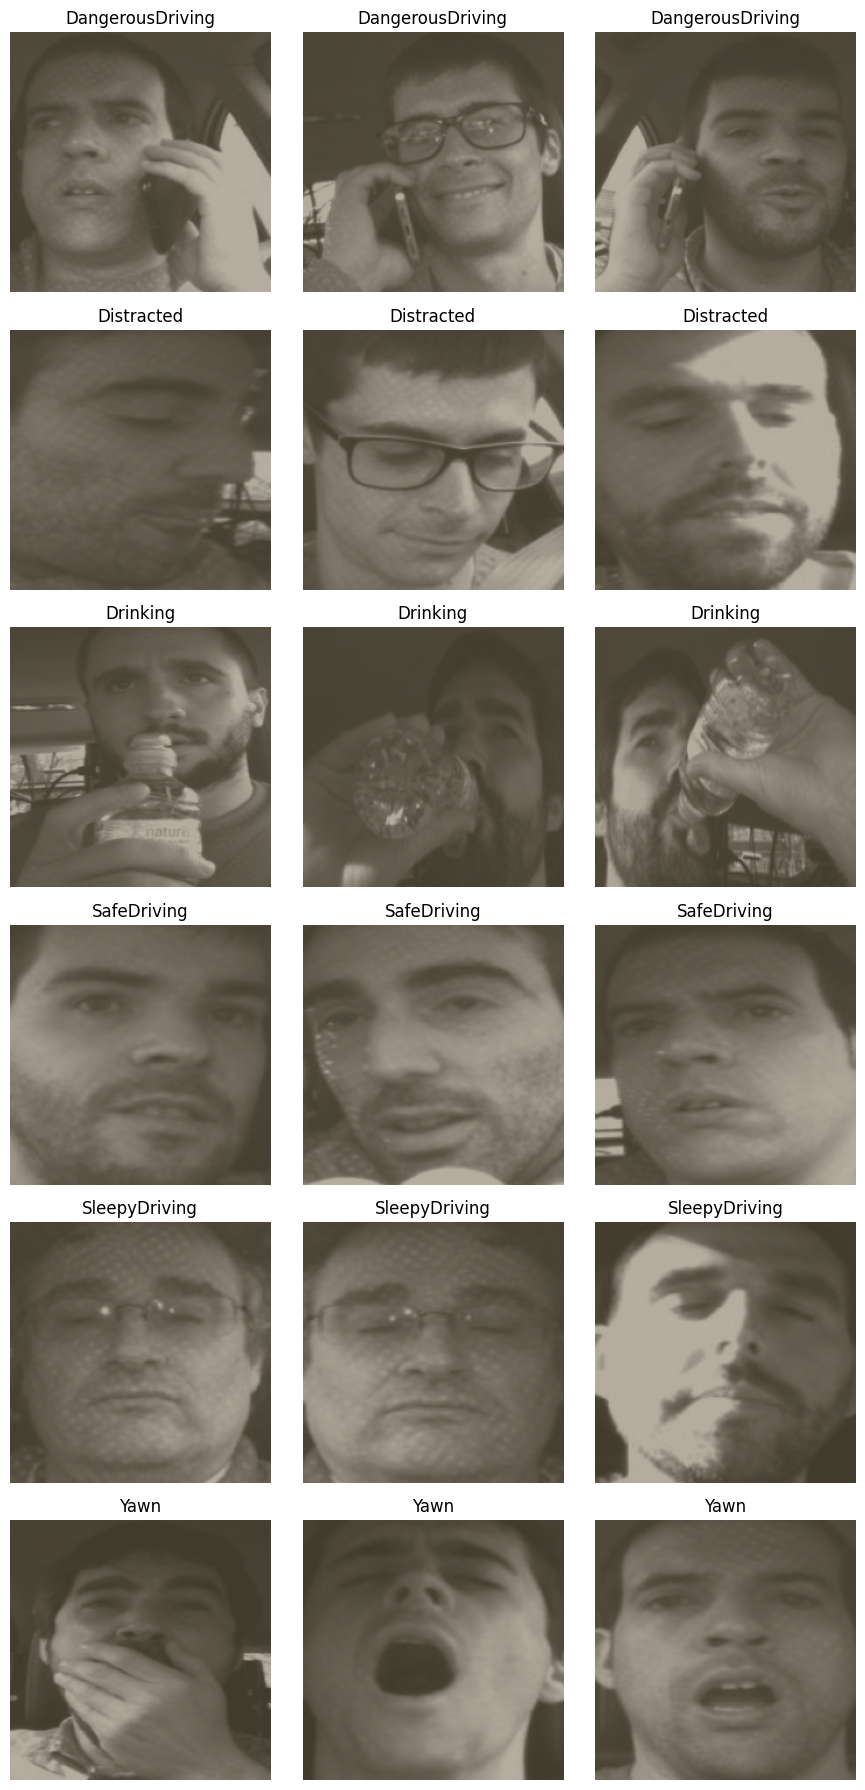


Validation Data Samples:


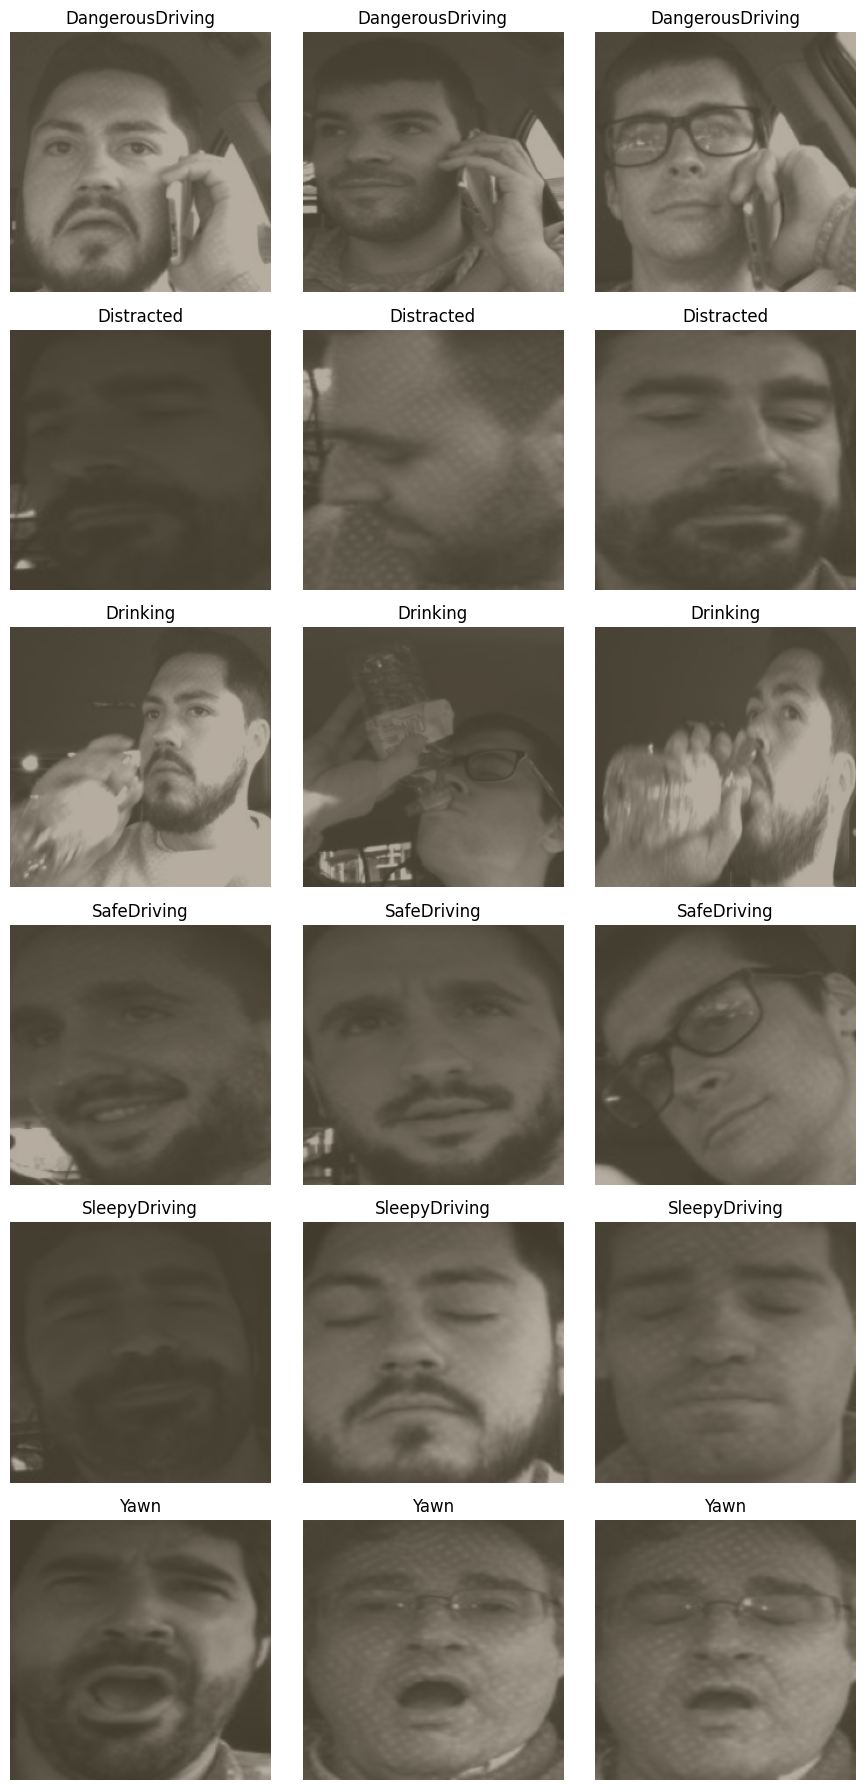

In [8]:
def visualize_samples(images, labels, class_names, n_samples=3):
    """Visualize sample images from each class"""
    class_indices = np.argmax(labels, axis=1)
    unique_classes = np.unique(class_indices)
    
    fig, axes = plt.subplots(len(unique_classes), n_samples, figsize=(n_samples*3, len(unique_classes)*3))
    
    if len(unique_classes) == 1:
        axes = np.array([axes])  # Handle case with just one class
    
    for i, cls in enumerate(unique_classes):
        # Get indices for this class
        cls_indices = np.where(class_indices == cls)[0]
        
        # Select random samples
        if len(cls_indices) >= n_samples:
            sample_indices = np.random.choice(cls_indices, n_samples, replace=False)
        else:
            sample_indices = cls_indices
            print(f"Warning: Class {cls} has only {len(cls_indices)} samples")
        
        # Display samples
        for j, idx in enumerate(sample_indices):
            if j < n_samples:  # Ensure we don't exceed the number of axes
                img = images[idx]
                
                # Denormalize if needed
                if img.min() < 0:
                    # Assuming ImageNet normalization
                    mean = np.array([0.485, 0.456, 0.406])
                    std = np.array([0.229, 0.224, 0.225])
                    img = img * std + mean
                    img = np.clip(img, 0, 1)
                
                ax = axes[i, j]
                ax.imshow(img)
                class_name = class_names[cls] if cls in class_names else f"Class {cls}"
                ax.set_title(f"{class_name}")
                ax.axis('off')
    
    plt.tight_layout()
    plt.show()

# Visualize samples from each dataset
print("Training Data Samples:")
visualize_samples(X_train, y_train, class_names)

print("\nValidation Data Samples:")
visualize_samples(X_val, y_val, class_names)

# Model Training

In [9]:
def build_efficient_net_model(model_version = 'B0'):

    model_mapping = {
        'B0': tf.keras.applications.EfficientNetB0,
        'B1': tf.keras.applications.EfficientNetB1,
        'B2': tf.keras.applications.EfficientNetB2,
        'B3': tf.keras.applications.EfficientNetB3,
        'B4': tf.keras.applications.EfficientNetB4,
    }
    
    if model_version not in model_mapping:
        raise ValueError(f"Unsupported model version: {model_version}")
    
    base_model = model_mapping[model_version](
        weights=None, 
        include_top=False, 
        input_shape=(224, 224, 3)
    )
    base_model.trainable = True
    
    model = tf.keras.models.Sequential([
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(6, activation='softmax')
    ])
    model.summary()

    # Count trainable parameters 
    trainable_params = np.sum([np.prod(v.shape) for v in model.trainable_variables])
    print(f"EfficientNet{model_version} - Trainable parameters: {trainable_params:,}")

    return model, trainable_params

In [13]:
def build_efficient_net_model(model_version='B0', use_residual=False):
    model_mapping = {
        'B0': tf.keras.applications.EfficientNetB0,
        'B1': tf.keras.applications.EfficientNetB1,
        'B2': tf.keras.applications.EfficientNetB2,
        'B3': tf.keras.applications.EfficientNetB3,
        'B4': tf.keras.applications.EfficientNetB4,
    }
    
    if model_version not in model_mapping:
        raise ValueError(f"Unsupported model version: {model_version}")
    
    base_model = model_mapping[model_version](
        weights=None, 
        include_top=False, 
        input_shape=(224, 224, 3)
    )
    base_model.trainable = True
    
    if use_residual:
        # Build model with residual connections using Functional API
        inputs = base_model.input
        x = base_model(inputs)
        x = tf.keras.layers.GlobalAveragePooling2D()(x)
        x = tf.keras.layers.BatchNormalization()(x)
        
        # First dense layer
        dense1 = tf.keras.layers.Dense(512, activation='relu', 
                                     kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
        dense1 = tf.keras.layers.Dropout(0.4)(dense1)
        
        # Second dense layer with residual connection
        dense2 = tf.keras.layers.Dense(512, activation='relu')(dense1)  # Same size for residual
        dense2 = tf.keras.layers.Dropout(0.3)(dense2)
        
        # Residual connection: Add input to output
        residual1 = tf.keras.layers.Add()([dense1, dense2])
        residual1 = tf.keras.layers.BatchNormalization()(residual1)
        residual1 = tf.keras.layers.Activation('relu')(residual1)
        
        # Third dense layer with another residual connection
        dense3 = tf.keras.layers.Dense(256, activation='relu')(residual1)
        dense3 = tf.keras.layers.Dropout(0.3)(dense3)
        
        # Project to same dimension for residual connection
        projected = tf.keras.layers.Dense(256, activation='relu')(residual1)
        residual2 = tf.keras.layers.Add()([projected, dense3])
        residual2 = tf.keras.layers.BatchNormalization()(residual2)
        residual2 = tf.keras.layers.Activation('relu')(residual2)
        
        # Final output layer
        outputs = tf.keras.layers.Dense(6, activation='softmax')(residual2)
        
        model = tf.keras.models.Model(inputs=inputs, outputs=outputs)
        
    else:
        # Original sequential model without residual connections
        model = tf.keras.models.Sequential([
            base_model,
            tf.keras.layers.GlobalAveragePooling2D(),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dense(512, activation='relu', 
                                kernel_regularizer=tf.keras.regularizers.l2(0.001)),
            tf.keras.layers.Dropout(0.4),
            tf.keras.layers.Dense(256, activation='relu'),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(6, activation='softmax')
        ])
    
    model.summary()

    # Count trainable parameters 
    trainable_params = np.sum([np.prod(v.shape) for v in model.trainable_variables])
    print(f"EfficientNet{model_version} - Trainable parameters: {trainable_params:,}")
    print(f"Using residual connections: {use_residual}")

    return model, trainable_params

In [14]:
class Trainer:
    def __init__(self, batch_size=16, class_names=class_names, model_version='B0', use_residual=Fal):
        self.model, self.trainable_params = build_efficient_net_model(model_version, use_residual)
        self.train_ds, self.val_ds, self.test_ds = self.create_datasets()
        self.class_weights = self.calc_class_weights()
        self.datagen = self.create_datagen()
        self.class_names = class_names
        
        # Callbacks
        self.callbacks = [
            tf.keras.callbacks.ModelCheckpoint(
                '/kaggle/working/best_model.weights.keras',
                save_best_only=True,
                monitor='val_loss'
            ),
            tf.keras.callbacks.EarlyStopping(
                monitor='val_loss',
                patience=7,  # It was 5
                restore_best_weights=True
            ),
            tf.keras.callbacks.ReduceLROnPlateau(
                monitor='val_loss', 
                factor=0.2, 
                patience=3, 
                min_lr=1e-6
            )
        ]

    def create_datasets(self):
        return (X_train, y_train), (X_val, y_val), (X_test, y_test)
        
    def calc_class_weights(self):
        class_weights = compute_class_weight(
            class_weight='balanced',
            classes=np.unique(np.argmax(self.train_ds[1], axis=1)),  # Convert one-hot back to indices
            y=np.argmax(self.train_ds[1], axis=1)
        )
        class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}
        
        # Boost underrepresented classes
        for key in class_weight_dict:
            if class_weight_dict[key] < 1.0:
                class_weight_dict[key] *= 1.5

        return class_weight_dict

    def create_datagen(self):
        # Data augmentation
        datagen = ImageDataGenerator(
            rotation_range=10,
            width_shift_range=0.1,
            height_shift_range=0.1,
            zoom_range=0.1,
            horizontal_flip=True,
            fill_mode='nearest'
        )

        return datagen

    def capture_and_save_results(self, model_version, history, training_start_time):
        """Captures and saves training results for model scaling analysis.
        
        Args:
            model_version: EfficientNet version (B0, B1, etc.)
            history: Training history object
            training_start_time: Time when training started (for calculating duration)
        """
        training_time = time.time() - training_start_time
        
        # Evaluate on test set
        test_results = self.model.evaluate(self.test_ds[0], self.test_ds[1], verbose=1)
        test_loss, test_accuracy = test_results
        
        # Create results dictionary
        results = {
            'model_version': model_version,
            'params': self.trainable_params,
            'training_history': {
                'accuracy': history.history['accuracy'],
                'loss': history.history['loss'],
                'val_accuracy': history.history['val_accuracy'],
                'val_loss': history.history['val_loss'],
                'learning_rate': history.history.get('lr', [])
            },
            'best_val_acc': max(history.history['val_accuracy']),
            'epoch_reached_best': np.argmax(history.history['val_accuracy']) + 1,
            'final_metrics': {
                'train_acc': history.history['accuracy'][-1],
                'val_acc': history.history['val_accuracy'][-1],
                'test_acc': test_accuracy,
                'test_loss': test_loss,
                'generalization_gap': history.history['accuracy'][-1] - history.history['val_accuracy'][-1]
            },
            'training_time_seconds': training_time,
            'avg_epoch_time': training_time / len(history.history['accuracy']),
            'epochs_trained': len(history.history['accuracy'])
        }

        # Save to file
        filename = f'/kaggle/working/model_results_{model_version}.json'
        
        # Convert numpy values to Python native types for JSON serialization
        def convert_to_serializable(obj):
            if isinstance(obj, np.float32) or isinstance(obj, np.float64):
                return float(obj)
            elif isinstance(obj, np.int32) or isinstance(obj, np.int64):
                return int(obj)
            elif isinstance(obj, np.ndarray):
                return obj.tolist()
            elif isinstance(obj, list):
                return [convert_to_serializable(item) for item in obj]
            elif isinstance(obj, dict):
                return {k: convert_to_serializable(v) for k, v in obj.items()}
            else:
                return obj
                
        results = convert_to_serializable(results)
        
        with open(filename, 'w') as f:
            json.dump(results, f, indent=2)
        
        print(f"Results for EfficientNet{model_version} saved to {filename}")
        return results

    def train(self, epochs, model_version):
        # Record start time
        training_start_time = time.time()
    
        # Warmup GPU
        dummy_data = tf.random.uniform((1, 224, 224, 3))
        self.model.predict(dummy_data)
        
        self.model.compile(
            optimizer=Adam(learning_rate=0.001, clipnorm=1.0),
            loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
            metrics=['accuracy']
        )

        history = self.model.fit(
            self.datagen.flow(self.train_ds[0], self.train_ds[1], batch_size=16),
            validation_data=self.val_ds,
            epochs=epochs,
            class_weight=self.class_weights,
            callbacks=self.callbacks
        )
        
        # Capture and save results
        results = self.capture_and_save_results(model_version, history, training_start_time)
        
        return history, results

In [15]:
# Create trainer and train model
model_version = 'B4'
use_residual = False
trainer = Trainer(batch_size=8, model_version=model_version, use_residual=use_residual)
history, results = trainer.train(epochs=30, model_version=model_version)

71686520/71686520 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb4 (Functional)          │ (None, 7, 7, 1792)          │      17,673,823 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 1792)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 1792)                │           7,168 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 512)                 │         918,016 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 6)                   │           1,542 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 18,731,877 (71.46 MB)

 Trainable params: 18,603,086 (70.97 MB)

 Non-trainable params: 128,791 (503.09 KB)

EfficientNetB4 - Trainable parameters: 18,603,086
Using residual connections: False
1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
747/747 ━━━━━━━━━━━━━━━━━━━━ 471s 321ms/step - accuracy: 0.6769 - loss: 2.8318 - val_accuracy: 0.4157 - val_loss: 1.9654 - learning_rate: 0.0010
Epoch 2/30
747/747 ━━━━━━━━━━━━━━━━━━━━ 123s 164ms/step - accuracy: 0.8301 - loss: 1.7503 - val_accuracy: 0.4157 - val_loss: 2.8561 - learning_rate: 0.0010
Epoch 3/30
747/747 ━━━━━━━━━━━━━━━━━━━━ 121s 162ms/step - accuracy: 0.8559 - loss: 1.1537 - val_accuracy: 0.1431 - val_loss: nan - learning_rate: 0.0010
Epoch 4/30


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:264: RuntimeWarning: invalid value encountered in less
  if self.monitor_op(current, self.best):
/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/reduce_lr_on_plateau.py:94: RuntimeWarning: invalid value encountered in less
  self.monitor_op = lambda a, b: np.less(a, b - self.min_delta)


747/747 ━━━━━━━━━━━━━━━━━━━━ 122s 163ms/step - accuracy: 0.8820 - loss: 0.9739 - val_accuracy: 0.4157 - val_loss: 4.0372 - learning_rate: 0.0010
Epoch 5/30
747/747 ━━━━━━━━━━━━━━━━━━━━ 127s 170ms/step - accuracy: 0.9085 - loss: 0.8576 - val_accuracy: 0.3814 - val_loss: 1.7851 - learning_rate: 2.0000e-04
Epoch 6/30
747/747 ━━━━━━━━━━━━━━━━━━━━ 121s 162ms/step - accuracy: 0.9464 - loss: 0.7176 - val_accuracy: 0.1420 - val_loss: 2.4174 - learning_rate: 2.0000e-04
Epoch 7/30
747/747 ━━━━━━━━━━━━━━━━━━━━ 121s 162ms/step - accuracy: 0.9529 - loss: 0.6957 - val_accuracy: 0.4168 - val_loss: 2.5056 - learning_rate: 2.0000e-04
Epoch 8/30
747/747 ━━━━━━━━━━━━━━━━━━━━ 126s 168ms/step - accuracy: 0.9613 - loss: 0.6691 - val_accuracy: 0.6436 - val_loss: 1.2301 - learning_rate: 2.0000e-04
Epoch 9/30
747/747 ━━━━━━━━━━━━━━━━━━━━ 122s 163ms/step - accuracy: 0.9612 - loss: 0.6586 - val_accuracy: 0.4173 - val_loss: 2.1670 - learning_rate: 2.0000e-04
Epoch 10/30
747/747 ━━━━━━━━━━━━━━━━━━━━ 122s 163ms/ste

In [ ]:
# After all models are trained, you can load the results for analysis
def load_all_results():
    all_results = {}
    for version in ['B1', 'B2', 'B3', 'B4']:
        try:
            with open(f'/kaggle/working/model_results_{version}.json', 'r') as f:
                all_results[version] = json.load(f)
        except FileNotFoundError:
            print(f"Results for {version} not found")
    return all_results

In [16]:
model_version = 'B4'
model, trainable_params = build_efficient_net_model(model_version)
model.load_weights('/kaggle/working/best_model.weights.keras')
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ efficientnetb4            │ (None, 7, 7, 1792)     │     17,673,823 │ input_layer_4[0][0]    │
│ (Functional)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d… │ (None, 1792)           │              0 │ efficientnetb4[0][0]   │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 1792)           │          7,168 │ global_average_poolin… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_6 (Dense)           │ (None, 512)            │        918,016 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_4 (Dropout)       │ (None, 512)            │              0 │ dense_6[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_7 (Dense)           │ (None, 512)            │        262,656 │ dropout_4[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_5 (Dropout)       │ (None, 512)            │              0 │ dense_7[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 512)            │              0 │ dropout_4[0][0],       │
│                           │                        │                │ dropout_5[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 512)            │          2,048 │ add[0][0]              │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 512)            │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_8 (Dense)           │ (None, 256)            │        131,328 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_9 (Dense)           │ (None, 256)            │        131,328 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_6 (Dropout)       │ (None, 256)            │              0 │ dense_8[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Add)               │ (None, 256)            │              0 │ dense_9[0][0],         │
│                           │                        │                │ dropout_6[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 256)            │          1,024 │ add_1[0][0]            │
│ (BatchNormalization) 

 Total params: 19,128,933 (72.97 MB)

 Trainable params: 18,998,606 (72.47 MB)

 Non-trainable params: 130,327 (509.09 KB)

EfficientNetB4 - Trainable parameters: 18,998,606
Using residual connections: True


ValueError: A total of 6 objects could not be loaded. Example error message for object <Dense name=dense_7, built=True>:

The shape of the target variable and the shape of the target value in `variable.assign(value)` must match. variable.shape=(512, 512), Received: value.shape=(512, 256). Target variable: <Variable path=dense_7/kernel, shape=(512, 512), dtype=float32, value=[[-0.0195137  -0.0162538  -0.04045138 ...  0.00512151 -0.00933687
  -0.00208677]
 [ 0.01686441  0.02171168 -0.05979754 ...  0.06852431  0.00214963
   0.02238821]
 [ 0.02326158  0.059059    0.00717565 ...  0.03675177 -0.04623131
  -0.04494253]
 ...
 [ 0.04316512 -0.03538863 -0.05343285 ...  0.06751477  0.06759407
  -0.02592632]
 [ 0.04877409 -0.06588285  0.07373684 ... -0.03805464  0.01309275
  -0.07315079]
 [-0.04633949 -0.03676259  0.04368369 ... -0.07409511  0.05510981
   0.03263009]]>

List of objects that could not be loaded:
[<Dense name=dense_7, built=True>, <BatchNormalization name=batch_normalization_3, built=True>, <Dense name=dense_8, built=True>, <Dense name=dense_9, built=True>, <BatchNormalization name=batch_normalization_4, built=True>, <Dense name=dense_10, built=True>]

In [ ]:
def evaluate_model(model, test_data):
    # Unpack the data
    X_test, y_test = test_data
    
    # Make predictions on the entire test set
    batch_predictions = model.predict(X_test)
    
    # Get predicted classes
    predicted_classes = np.argmax(batch_predictions, axis=1)
    true_classes = np.argmax(y_test, axis=1)  # Convert one-hot to class indices
    
    # Calculate metrics
    print("\nClassification Report:")
    class_names_list = list(class_names.values())  # Assuming class_names is available
    print(classification_report(true_classes, predicted_classes, target_names=class_names_list))
    
    # Plot confusion matrix
    cm = confusion_matrix(true_classes, predicted_classes)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names_list, 
                yticklabels=class_names_list)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()
    
    # Print additional metrics
    print("\nDetailed Metrics:")
    print(f"Total samples: {len(true_classes)}")
    print(f"Accuracy: {(true_classes == predicted_classes).mean():.4f}")
    
    # Calculate per-class accuracy
    for i in range(len(class_names)):
        class_mask = true_classes == i
        if np.any(class_mask):  # Check if there are any samples in this class
            class_acc = (predicted_classes[class_mask] == i).mean()
            print(f"Class {i} ({class_names[i]}) accuracy: {class_acc:.4f}")
        else:
            print(f"Class {i} ({class_names[i]}): No samples")
    
    return batch_predictions, true_classes

predictions, true_labels = evaluate_model(model, (X_test, y_test))